# Introdução (não-extensiva) a Online Learning


**Saulo Martiello Mastelini** (mastelini@usp.br)

Outras redes:

- [Github](https://github.com/smastelini)
- [Linkedin](https://www.linkedin.com/in/smastelini/) (eu deveria, mas não atualizo frequentemente -- para ser sincero, está muito desatualizado)
- [ResearchGate](https://www.researchgate.net/profile/Saulo-Mastelini)

MBA em Ciência de Dados<br>
Universidade de São Paulo, São Carlos, Brasil<br>
Copyright (c) 2021

---

**Disclaimer**

Como o título já diz, essa não é, de forma alguma, uma introdução extensiva ao tema. É apenas a minha humilde tentativa de dar um panorama geral de décadas de pesquisa em uma área que está em constante expansão e inovação.

Feliz ou infelizmente, todo processo de aprendizado leva tempo. Assim, não será possível aprofundar em toda uma área de pesquisa de décadas em apenas algumas horas.

Pretendo me inspirar na pesquisa em estruturas de árvores (teoria dos grafos) para guiar nosso estudo. Vou mostrar três opções (a última customizada ao meu gosto), das quais as duas primeiras eu quero evitar:

1. **Busca em largura:** corremos o risco de não abordar tudo o que há de mais popular e, ainda por cima, sermos tão superficiais que os conteúdos seriam de pouca valia.
2. **Busca em profundidade:** aqui o risco é querer focar muito em um minúcias ou em um ponto específico e acabar não tendo um panorama geral das coisas.
3. **Busca em profundidade limitada** (e adaptativa) **:** Nos aprofundaremos um pouco em cada tópico, não muito, mas se quiserem, podemos nos aprofundar mais. Cabe a vocês pedirem! No entanto, me reservo ao direito de arbitrar o quanto devemos insistir num assunto durante nosso escasso tempo: buscarei balancear interesses individuais e o coletivo, bem como julgar o que pode ou não ajudar no estudo individual de cada um.

---

**Ponto de partida para aprofundamento**

Para quem quiser se aprofundar mais nos assuntos que eu vou apresentar hoje, eu sugiro os seguintes recursos:

- [Livro do MOA](https://moa.cms.waikato.ac.nz/book-html/): um livro de acesso aberto que abrange vários tópicos ligados a stream learning
- [Documentação do River](https://riverml.xyz/dev/): conta com vários exemplos e tutoriais, além de referenciais práticos e teóricos! Está sempre sendo expandida, corrigida e atualizada.

Quem tiver alguma dúvida específica que a documentação não possa suprir pode sempre abrir uma "*Discussion*" no Github. É só ir no [repositório do Github do River](https://github.com/online-ml/river) e clicar na aba de discussões. Alguém da equipe de desenvolvimento ou da comunidade de usuários do River com grande certeza estará disposto a ajudar!

Contribuições são bem vindas! O River é um projeto *Open Source* construído pela comunidade. Mesmo que alguém possa não ter conhecimento técnico dos algoritmos, sempre é possível ajudar! Correções e expansões na documentação, por exemplo, são formas de ajudar! Muitas vezes apontar erros ou bugs (através de *issues*) já é de grande ajuda! 😁

---

**Sobre o River**

O River é um projeto open source para online learning e stream mining. Ele surgiu a partir da fusão de duas ferramentas (também open-source):

- creme
- scikit-multiflow

Ambos os pacotes Python abordavam o mesmo tema, mas com enfoques específicos. Após um longo tempo de planejamento e conversas, os mantenedores e times de desenvolvimento dos dois pacotes uniram forças e lançaram o River. O novo pacote é o produto dos anos de lições aprendidas no desenvolvimento das ferramentas predecessoras.

O River reune o que havia de melhor `creme` e `scikit-multiflow` (que foram descontinuados) e supera pontos fracos que existiam nos projetos anteriores. A nova ferramenta é voltada tanto para o uso no mercado quanto na academia.

O River conta com muitos contribuidores, mas a maioria do time de desenvolvimento está distribuído entre a França, Nova Zelândia e Brasil.

O artigo da ferramenta no JMLR pode ser acessado [aqui](https://www.jmlr.org/papers/v22/20-1380.html).

O site do River é o: https://riverml.xyz

Existe muita demanda e nem tanto tempo 😅. Se quiserem checar os planos para o futuro, visitem o nosso [Roadmap](https://www.notion.so/d1e86fcdf21e4deda16eedab2b3361fb?v=503f44740b8b44a99a961aa96e9e46e1).

---

## Sumário
1. Online learning? Why?
2. Batch vs. Online
3. Estruturas necessárias: exemplo
    - Mean
    - Var
    - Quantile
4. Por que usar dicionários?
    - Exemplos com dados faltantes
5. Como avaliar um modelo?
    - `progressive_val_score`
    - label delay
6. Concept drift
7. Exemplos de algoritmos
    1. Classificação
        1. Logistic regression
        2. Hoeffding Tree
        3. Naive Bayes
        4. Adaptive Random Forest
        5. Streaming Random Patches
    2. Regressão
        1. Linear Regression
        2. Hoeffding Tree
        3. AMRules
        4. Adaptive Random Forest
        5. Streaming Random Patches
    3. Clustering
        1. k-Means
        2. CluStream
        3. DenStream
        4. DBSTREAM
    4. Anomaly detection
        1. Half-space Trees
8. Expert module
9. Pipelines e pré-processamento
    - Encoding
    - Scaling
    - Filtragem e Seleção
    - Aritmética com Pipelines
    - Visualizando as coisas
10. Exemplo completo
    - processamento em tempo real
    - inspeção de modelos

In [1]:
# Esses são os pacotes que estão sendo utilizados nesse notebook
# As linhas a seguir podem ser descomentadas para instalar o que for necessário

# !pip install numpy
# !pip install scikit-learn
# !pip install river

# 1. Online Learning? Why?

Por que alguém deveria se preocupar em atualizar modelos a todo tempo? Não é só treinar e sair usando?

R: sim! Em grande parte dos casos isso é verdade.

Mas imagine que:

- A quantidade de dados produzidas é enorme
- Não é possível armazenar tudo
- Existe limitação no poder computacional para treinamento dos modelos
    - processador
    - memória
    - bateria
- Os dados são não-estacionários e/ou evoluem com o tempo

Nesses casos, posso usar aprendizado de máquina tradicional? R: sim!!

É possível usar aprendizado de máquina tradicional se:
- Os dados são estacionários (uma amostra representativa dos dados é suficiente)

ou

- A velocidade de produção dos dados não é tão alta (batch-incremental e os recursos computacionais são suficientes

## 1.1 Batch-incremental


Um modelo tradicional de aprendizado de máquina é re-treinado de tempos em tempos. Para tal, uma janela para treinamento precisa ser definida.

Tipos de janelamento dos dados:


<img src="time_windows.png">

**Fonte:** Adaptado de:

> Carnein, M. and Trautmann, H., 2019. Optimizing data stream representation: An extensive survey on stream clustering algorithms. Business & Information Systems Engineering, 61(3), pp.277-297.

- *Landmarks* são a escolha mais comum em estratégias batch-incremental. É preciso definir o tamanho da janela de forma adequada.
    - O modelo pode ficar defasado se a janela for muito grande 
    - Ou o modelo pode não capturar os padrões se a janela for muito pequena
    - Concept-drift é um problema e tanto
    
**Atenção**: batch-incremental != mini-batch.
Redes neurais podem ser treinadas de forma incremental ou progressiva. No entanto, questões como "esquecimento catastrófico" são problemáticas. Esse e outros tipos de desafios são tratados na área de pesquisa chamada **continual learning**.

## 1.2 Importante lembrar

Data streams não são, necessariamente, séries temporais! 🤯

Mas qual é a diferença, então?

Basicamente, em streams não necessariamente temos dependências temporais explícitas como em séries temporais. Por exemplo: rede de sensores.

Os dados chegam temporalmente organizados, mas cada sensor tem uma taxa de transmissão específica, ou um delay específico. Alguns sensores pode falhar... outros serem adicionados. E assim por diante.

A ordem de chegada não importa... tanto, mas importa.

# 2. Batch vs. Online

Uma boa introdução acerca da "migração" de batch para online está disponível no [site](https://riverml.xyz/latest/examples/batch-to-online/) do River. Aqui eu só quero dar uma visão bem geral das diferenças. Entraremos em mais detalhes posteriormente nas minúcias de avaliação de modelos em Online Learning.


Uma possível validação de um modelo tradicional de aprendizado de máquina poderia ter essa "cara":

In [2]:
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

data = load_wine()

X, y = data.data, data.target
kf = KFold(shuffle=True, random_state=8, n_splits=10)

accs = []

for train, test in kf.split(X):
    X_tr, X_ts = X[train], X[test]
    y_tr, y_ts = y[train], y[test]
    
    dt  = DecisionTreeClassifier(max_depth=5, random_state=93)
    dt.fit(X_tr, y_tr)
    
    accs.append(accuracy_score(y_ts, dt.predict(X_ts)))

print(f"Acurácia média: {sum(accs) / len(accs)}")

Acurácia média: 0.9045751633986928


Reparem que todo o conjunto de dados está disponível e carregado em memória. O algoritmo de árvore de decisão pode percorrer os dados de treino quantas vezes forem necessárias. Os dados de teste (validação, no nosso caso) nunca são utilizados para treino.

No fim das contas, usaríamos o conjunto completo para treinar um modelo final (supondo que já encontramos um conjunto adequado de hiper-parâmetros). Uma vez treinado, esse modelo seria utilizado para fazer predições para novas amostras (de vinhos, nesse caso).

In [3]:
from river import metrics
from river import stream
from river import tree


acc = metrics.Accuracy()
ht = tree.HoeffdingTreeClassifier(max_depth=5, grace_period=20)

for x, y in stream.iter_sklearn_dataset(load_wine()):
    # Métrica atualizada antes do treinamento
    acc.update(y, ht.predict_one(x))
    # Modelo treinado amostra-a-amostra
    ht.learn_one(x, y)

print(f"Acurácia: {acc.get()}")

Acurácia: 0.9269662921348315


Aqui, estamos percorrendo cada exemplo do conjunto de dados de forma sequencial. Os exemplos poderiam ser carregados diretamente do disco, de algum webservice, ou de onde sua imaginação te levar, sem a necessidade de salvar em memória nada.

Cada amostra é primeiramente utilizada para teste e depois passada para o modelo. Tudo é atualizado uma amostra por vez. Notem que não podemos comparar diretamente os desempenhos obtidos porque a estratégia de avaliação foi diferente nos dois casos.

Poderíamos ainda (pseudo) embaralhar os dados antes de passar para o modelo, se temos plena confiança que os dados são estacionários.

# 3. Estruturas necessárias: exemplo

In [4]:
import numpy as np
from river import stats

Dado esse choque inicial, vamos prosseguir com calma e primeiramente pensar em alguns aspectos importantes antes de vermos os algoritmos de aprendizado de máquina online.

## 3.1. Um exemplo, para aquecimento cerebral

Vamos supor que queremos calcular estatísticas para dados que chegam a todo momento:

- Média
- Variância
- ...

Hora de simular:

In [5]:
import random

rng = random.Random(42)

In [6]:
%%time

valores = []
stds_batch = []

for _ in range(50000):
    v = rng.gauss(5, 3)
    valores.append(v)
    
    stds_batch.append(np.std(valores))

CPU times: user 1min 9s, sys: 36.8 ms, total: 1min 9s
Wall time: 1min 9s


Por padrão o numpy calcula o desvio padrão populacional! Para usar a versão amostral precisamos passar `ddof=1` como parâmetro.

In [7]:
rng = random.Random(42)

In [8]:
%%time

stds_incr = []
var = stats.Var(ddof=0)

for _ in range(50000):
    v = rng.gauss(5, 3)
    var.update(v)
    stds_incr.append(var.get() ** 0.5)

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 111 ms


Será que dá alguma diferença? E será que funciona?

In [9]:
s_erros = 0

for batch, incr in zip(stds_batch, stds_incr):
    s_erros += (batch - incr)

s_erros, s_erros / len(stds_batch)

(4.301100448023121e-10, 8.602200896046241e-15)

Ok... parece convincente. Mas e se o cenário fosse diferente? Se ao invés de calcularmos o desvio padrão e irmos aumentando a quantidade de dados, quisessemos descobrir um percentil das últimas `N` amostras?

In [10]:
rng = random.Random(42)

tam = 10000

In [11]:
%%time


buffer = []
percs75_batch = []

for _ in range(100000):
    v = rng.uniform(-100, 100)
    buffer.append(v)
    if len(buffer) <= tam:
        continue
        
    percs75_batch.append(np.quantile(buffer, q=0.75))
    buffer.pop(0)

CPU times: user 1min 2s, sys: 43.7 ms, total: 1min 2s
Wall time: 1min 2s


Podemos fazer um pouco melhor que isso.

In [12]:
rng = random.Random(42)

In [13]:
%%time

qtl = stats.RollingQuantile(window_size=tam, q=0.75)
percs75_incr = []

for _ in range(100000):
    v = rng.uniform(-100, 100)
    qtl.update(v)
    if len(qtl) <= tam:
        continue
        
    percs75_incr.append(qtl.get())

CPU times: user 8.35 s, sys: 0 ns, total: 8.35 s
Wall time: 8.35 s


In [14]:
s_erros = 0

for batch, incr in zip(percs75_batch, percs75_incr):
    s_erros += (batch - incr)

s_erros

0

Espero tê-los convencido! O [módulo](https://riverml.xyz/dev/api/overview/#stats) `stats` do River tem várias funções úteis para sumarização de dados de forma incremental. Vale a pena checar! 🧐

A razão pela qual eu quis mostrar tudo isso é porque vários desses algoritmos são os "tijolos" que compõem os algoritmos de aprendizado de máquina. Uma receita breve para online learning:

- A junção de métricas estatísticas incrementais
- Algumas grandezas probabilísticas
- Algumas teorias de aprendizado de máquina que são genéricas e não limitadas ao cenário in-batch
- Gradiente descendente
- *otras cositas*

Com isso tudo é possível formar boa parte dos algoritmos de aprendizado incremental. Mas isso é extremamente genérico de se dizer, não é? Bom, no fim das contas, o aprendizado de máquina tradicional também "se resume" a algumas coisas pontuais, mas que são extremamente abrangentes por si só.

Que tal entendermos um pouco de como os exemplos anteriores funcionam e por que eles funcionam?

## 3.2. Uma (extremamente) breve reflexão sobre complexidade dos algoritmos

Quanto custa para calcular a variância (no caso, desvio padrão) e o percentil nos exemplos anteriores?

**Modo batch**

Variância:  $\dfrac{\sum_i^N (x_i - \bar{x})}{N - 1}$

- Média é calculada com o custo $O(n)$ -> todos os elementos devem ser somados e divididos pelo total de observações
- Com a média em mãos, precisamos calcular o desvio de cada elemento para a média e somar tais desvios: $O(n)$
- No fim das contas, o custo final é $O(n)$ (na notação assintótica), mas tivemos que percorrer todos os dados duas vezes (e, consequentemente, armazená-los).
- Esse algoritmo também apresenta problemas de estabilidade, quando o número de observações é muito grande. Pode gerar erros numéricos de aproximação.

Percentil:

- Pegue um exemplo novo e remova o mais antigo
- Ordene os dados: algo em torno de $O(n\log n)$ (n é o tamanho do buffer)
- Encontre a posição correta, interpole e retorne

Se esse processo é repetido várias e várias vezes...

**Modo incremental**


Variância (algoritmo de Welford):

- Precisamos de algumas variáveis:
    - $n$: número de observações
    - $\overline{x}_n$: a média da amostral, após $n$ observações
    - $M_{2, n}$: estatística de segunda ordem que gerará a variância
- As atualizações das estatísticas se dão na seguinte forma:
    - $\overline{x}_n = \overline{x}_{n-1} + \dfrac{x_n - \overline{x}_{n-1}}{n}$
    - $M_{2,n} = M_{2,n-1} + (x_n - \overline{x}_{n-1})(x_n - \overline{x}_n)$
- E as estatísticas são inicializadas da seguinte forma:
    - $\overline{x}_{0} \leftarrow 0$
    - $M_{2,0} \leftarrow 0$
- Para obter a variância amostral basta usar: $s_n^2 = \dfrac{M_{2,n}}{n-1}$, para todo $n > 1$
- De brinde, obtemos um preditor robusto para a média 🤓


Percentil:

- Mantemos dois buffers
   - Um com os dados na ordem em que chegam
   - Outro com os dados ordenados: o custo de inserção de um novo ponto em um vetor já ordenado é $O(\log n)$
   - A remoção de um valor no buffer ordenado é $O(n)$. No buffer não-ordenado é $O(1)$
   - O cálculo do percentil usa o buffer ordenado
   
No fim das contas, sempre buscamos que cada atualização em uma métrica ou modelo de aprendizado tenha um custo constante ($O(1)$). Se isso não for possível, então um custo sub-linear é o objetivo!

---

Antes de prosseguirmos, vou mostrar mais uma aplicação legal de métricas incrementais, com requintes de processamento distribuido.

**Situação hipotética:**

E se estivéssemos calculando estatísticas de alguma coisa, mas a coleta era feita de forma separada? Por exemplo, estamos calculando a variância de alguma coisa a nível estadual, mas a coleta é feita por município?

(Eu sou paranaense)

In [15]:
rng = random.Random(7)

In [16]:
dados_ca = [rng.gauss(1500, 200) for _ in range(15000)]
dados_lndrn = [rng.gauss(2500, 500) for _ in range(600000)]

np.var(dados_ca), np.var(dados_lndrn)

(39496.429786146546, 249442.43568603016)

E se quisermos calcular a variância (ou média) total de todos os municípios?

In [17]:
dados_parana = []

# dados_parana.extend(dados_abatiá)
# ...
dados_parana.extend(dados_ca)
# ...
dados_parana.extend(dados_lndrn)
# ...
# dados_parana.extend(dados_xambrê)

len(dados_parana)

615000

In [18]:
np.var(dados_parana)

268085.14104958007

In [19]:
np.mean(dados_parana)

2475.927394402956

Nós já sabemos como fazer esse mesmo processo de forma incremental:

In [20]:
# estou considerando que todos os dados foram coletados, mas poderia usar o padrão, ddof=1
var_ca = stats.Var(ddof=0)
var_lndrn = stats.Var(ddof=0)

for p in dados_ca:
    var_ca.update(p)
    
for p in dados_lndrn:
    var_lndrn.update(p)

In [21]:
var_ca.get(), var_lndrn.get()

(39496.429786146546, 249442.4356860276)

Posso usar `stats.Mean` para obter a média. Mas se lembrarmos bem, o algoritmo de Welford tem um preditor de média "lá no meio", não tem?

Voilà!

In [22]:
var_ca.mean.get(), np.mean(dados_ca)

(1500.9742744265895, 1500.9742744265982)

Agora vem a parte mais legal 🙃

Como obtemos as estatísticas para o estado inteiro?

In [23]:
# Imagine que temos um for somando as estatísticas de todos os estados

var_parana = var_ca + var_lndrn  # + os outros municipios

var_parana.get(), np.var(dados_parana)

(268085.1410495726, 268085.14104958007)

In [24]:
var_parana.mean.get(), np.mean(dados_parana)

(2475.927394402848, 2475.927394402956)

E se a bela e formosa cidade de Cândido de Abreu tivesse sido esquecida? Os dados tivessem sido perdidos, sei lá...

(quando eu era criança, minha cidade nem aparecia nos mapas impressos do Paraná, vai saber...)

In [25]:
var_ca_backup = var_parana - var_lndrn  # - os outros municipios

In [26]:
var_ca.get(), var_ca_backup.get()

(39496.429786146546, 39496.42978614286)

In [27]:
var_ca.mean.get(), var_ca_backup.mean.get()

(1500.9742744265895, 1500.9742744265875)

No fim das contas, sempre existe um trade-off entre memória e tempo de processamento (e a quantidade de "passadas" nos dados) e a precisão dos resultados obtidos. Muitos dos algorítmos de online learning incluem um parâmetro ($\delta$) que indica a porcentagem de "certeza" que você deseja ter nos seus resultados. Em geral, quanto mais certeza, mais tempo leva para tomar as decisões.


# 4. Por que usar dicionários (ou, por que usar uma representação esparsa)?

Um as primeiras coisas que podem chamar a atenção no River é o tipo de dados que é utilizado: dicionários python.

- Chave x valor: chaves são únicas
- Valores acessados via chave, ao invés de índice
- Dicionários são estruturas naturalmente esparsas
- Diferentemente de arrays, vetores, matrizes (e etc.) não possuem uma ordenação explícita
- Podem ser extendidos
- Podem ter variáveis de tipo misto

Exemplos:

In [28]:
from datetime import datetime

x = {
    "batata": 3,
    "carro": 2,
    "data": datetime.now(),
    "sim_ou_não": "sim"
}

x

{'batata': 3,
 'carro': 2,
 'data': datetime.datetime(2021, 8, 30, 16, 35, 46, 971294),
 'sim_ou_não': 'sim'}

In [29]:
x["mais um"] = True
x

{'batata': 3,
 'carro': 2,
 'data': datetime.datetime(2021, 8, 30, 16, 35, 46, 971294),
 'sim_ou_não': 'sim',
 'mais um': True}

In [30]:
del x["data"]
x

{'batata': 3, 'carro': 2, 'sim_ou_não': 'sim', 'mais um': True}

Esse tipo de estrutura é muito parecida com o popular formato JSON (para transferência de dados)!

Que tal compararmos com o que é mais usual?

In [31]:
data = load_wine()

X, y = data.data, data.target

X[0, :], data.feature_names

(array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03]),
 ['alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'flavanoids',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity',
  'hue',
  'od280/od315_of_diluted_wines',
  'proline'])

In [32]:
y[0], data.target_names

(0, array(['class_0', 'class_1', 'class_2'], dtype='<U7'))

Primeiramente, vamos colocar o sklearn à prova.

In [33]:
X_tr, y_tr = X[:-2, :], y[:-2]
X_ts, y_ts = X[-2:, :], y[-2:]

X_tr.shape, X_ts.shape

((176, 13), (2, 13))

In [34]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_tr, y_tr)

nb.predict(X_ts)

array([2, 2])

Mas, e se uma feature estivesse faltando?

In [35]:
try:
    nb.predict(X_ts[:, 1:])
except ValueError as error:
    print(error)

operands could not be broadcast together with shapes (2,12) (13,) 


Em Online Learning nós não deveríamos ficar nos preocupando com "coisa pouca" assim. Brincadeiras a parte, em um cenário de aprendizado online, sensores podem falhar, novos dados podem surgir, entre muitas outras coisas que podem alterar os dados de entrada. Precisamos de uma representação e modelos robustos quanto a isso!

Com o River, a vasta maioria dos modelos está pronta para lidar com esse tipo de problema! 🎉

In [36]:
from river import naive_bayes

gnb = naive_bayes.GaussianNB()
dataset = stream.iter_sklearn_dataset(load_wine())

rng = random.Random(42)

# Chance de feature ser ignorada
del_chance = 0.2

n_linhas_incompletas = 0
for i, (x, y) in enumerate(dataset):
    if i == 176:
        break
    
    x_copy = x.copy()
    aux = 0
    for xi in x:
        if rng.random() <= del_chance:
            del x_copy[xi]
            aux = 1
        
        # Atualiza o número de linhas incompletas
        n_linhas_incompletas += aux
    
    gnb.learn_one(x_copy, y)

In [37]:
x, y

({'alcohol': 13.17,
  'malic_acid': 2.59,
  'ash': 2.37,
  'alcalinity_of_ash': 20.0,
  'magnesium': 120.0,
  'total_phenols': 1.65,
  'flavanoids': 0.68,
  'nonflavanoid_phenols': 0.53,
  'proanthocyanins': 1.46,
  'color_intensity': 9.3,
  'hue': 0.6,
  'od280/od315_of_diluted_wines': 1.62,
  'proline': 840.0},
 2)

In [38]:
gnb.predict_proba_one(x)

{0: 2.2901730526821133e-23, 1: 4.523692607178262e-14, 2: 0.9999999999999538}

Vamos bagunçar a última amostra:

In [39]:
x, y = next(dataset)
list(x.keys())

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

Vou tirar um cópia do `x` e remover umas coisas

In [40]:
x_copy = x.copy()

del x_copy["malic_acid"]
del x_copy["hue"]
del x_copy["flavanoids"]

x_copy

{'alcohol': 14.13,
 'ash': 2.74,
 'alcalinity_of_ash': 24.5,
 'magnesium': 96.0,
 'total_phenols': 2.05,
 'nonflavanoid_phenols': 0.56,
 'proanthocyanins': 1.35,
 'color_intensity': 9.2,
 'od280/od315_of_diluted_wines': 1.6,
 'proline': 560.0}

Será que o nosso modelo dá conta do recado?

In [41]:
gnb.predict_proba_one(x_copy), y

({0: 7.394823717897321e-13, 1: 8.511456030879924e-13, 2: 0.9999999999984084},
 2)

E se ao invés de diminuir o número de features aumentasse?

In [42]:
x["primeira extra"] = 7.89
x["segunda extra"] = 2

x

{'alcohol': 14.13,
 'malic_acid': 4.1,
 'ash': 2.74,
 'alcalinity_of_ash': 24.5,
 'magnesium': 96.0,
 'total_phenols': 2.05,
 'flavanoids': 0.76,
 'nonflavanoid_phenols': 0.56,
 'proanthocyanins': 1.35,
 'color_intensity': 9.2,
 'hue': 0.61,
 'od280/od315_of_diluted_wines': 1.6,
 'proline': 560.0,
 'primeira extra': 7.89,
 'segunda extra': 2}

In [43]:
gnb.learn_one(x, y)

gnb.predict_one({"primeira extra": 7.8, "segunda extra": 1.5})

1

In [44]:
np.unique(data.target, return_counts=True)

(array([0, 1, 2]), array([59, 71, 48]))

Cada tipo de modelo implementa estratégias diferentes para lidar com atributos emergentes ou faltantes!

No nosso exemplo, "1" era a classe majoritária. Essa foi a escolha feita pelo GaussianNB, já que há pouca informação acerca dos dois atributos extra que adicionamos. Mas eles já fazem parte do modelo e serão atualizados caso novas observações cheguem!

In [45]:
gnb.gaussians

defaultdict(functools.partial(<class 'collections.defaultdict'>, <class 'river.proba.gaussian.Gaussian'>),
            {0: defaultdict(river.proba.gaussian.Gaussian,
                         {'alcohol': 𝒩(μ=13.751, σ=0.434),
                          'ash': 𝒩(μ=2.473, σ=0.234),
                          'alcalinity_of_ash': 𝒩(μ=16.896, σ=2.671),
                          'magnesium': 𝒩(μ=107.082, σ=10.720),
                          'total_phenols': 𝒩(μ=2.811, σ=0.286),
                          'flavanoids': 𝒩(μ=2.955, σ=0.367),
                          'proanthocyanins': 𝒩(μ=1.881, σ=0.399),
                          'hue': 𝒩(μ=1.077, σ=0.119),
                          'od280/od315_of_diluted_wines': 𝒩(μ=3.131, σ=0.348),
                          'malic_acid': 𝒩(μ=1.982, σ=0.661),
                          'nonflavanoid_phenols': 𝒩(μ=0.288, σ=0.071),
                          'color_intensity': 𝒩(μ=5.443, σ=1.342),
                          'proline': 𝒩(μ=1114.224, σ=228.521),
    

# 5. Como avaliar um modelo?

Já vimos em exemplos passados que os dados foram primeiramente utilizados para teste e depois para treino. Nada de Cross-validation, Leave-one-out, holdout e coisas do tipo.

Esse tipo de avaliação se aproxima mais de um cenário de produção real. Normalmente, obtemos um dado sem a sua label (no caso supervisionado, obviamente) e precisamos fazer predições. Só depois de um tempo a verdadeira label daquele exemplo será conhecida.

Nos exemplos até aqui, nós assumimos que logo após o treinamento do modelo com uma amostra, a label é revelada. No entanto, um cenário ainda mais realístico é aquele onde existe um *delay* entre a predição e a chegada da label. Em alguns casos, certos exemplos podem nunca ter sua label obtida!

Esse tipo de estratégia de avaliação é chamada de "validação progressiva" (*progressive validation*) ou "*prequential*".

Deixo esse [ótimo post do Max Halford](https://maxhalford.github.io/blog/online-learning-evaluation/), onde esse tema é discutido em detalhes.

No River, podemos utilizar a função `progressive_val_score` disponível no módulo `evaluate` para realizar validações progressivas! Daqui para frente, essa função será utilizada.

Obviamente, podemos também escrever alguns `for` e customizar a estratégia de avaliação. Fica de acordo com o critério e a necessidade de cada um!

In [46]:
from river import evaluate
from river import metrics
from river import synth


def label_delay(x, y):
    return rng.randint(0, 100)


rng = random.Random(8)
dataset = synth.RandomRBF(seed_sample=7, seed_model=9)
model = tree.HoeffdingTreeClassifier()

# Podemos combinar métricas com operadores de pipeline!
metric = metrics.Accuracy() + metrics.MicroF1() + metrics.BalancedAccuracy()

evaluate.progressive_val_score(
    dataset=dataset.take(50000),
    model=model,
    metric=metric,
    print_every=5000,
    show_memory=True,
    show_time=True,
    delay=label_delay
)

[5,000] Accuracy: 69.65%, MicroF1: 0.696532, BalancedAccuracy: 69.12% – 0:00:02.272247 – 84.42 KB
[10,000] Accuracy: 72.09%, MicroF1: 0.720893, BalancedAccuracy: 71.42% – 0:00:04.363503 – 90.96 KB
[15,000] Accuracy: 73.55%, MicroF1: 0.735539, BalancedAccuracy: 73.12% – 0:00:05.784046 – 156.28 KB
[20,000] Accuracy: 75.60%, MicroF1: 0.756016, BalancedAccuracy: 75.22% – 0:00:08.030560 – 199.82 KB
[25,000] Accuracy: 78.33%, MicroF1: 0.783345, BalancedAccuracy: 78.02% – 0:00:09.915172 – 243.4 KB
[30,000] Accuracy: 80.23%, MicroF1: 0.802261, BalancedAccuracy: 80.00% – 0:00:12.113265 – 308.72 KB
[35,000] Accuracy: 81.62%, MicroF1: 0.816199, BalancedAccuracy: 81.43% – 0:00:14.306578 – 374.04 KB
[40,000] Accuracy: 82.81%, MicroF1: 0.828103, BalancedAccuracy: 82.63% – 0:00:16.167678 – 439.36 KB
[45,000] Accuracy: 83.74%, MicroF1: 0.837382, BalancedAccuracy: 83.57% – 0:00:18.097457 – 460.53 KB
[50,000] Accuracy: 84.52%, MicroF1: 0.845226, BalancedAccuracy: 84.36% – 0:00:19.968332 – 504.68 KB


Accuracy: 84.52%, MicroF1: 0.845226, BalancedAccuracy: 84.36%

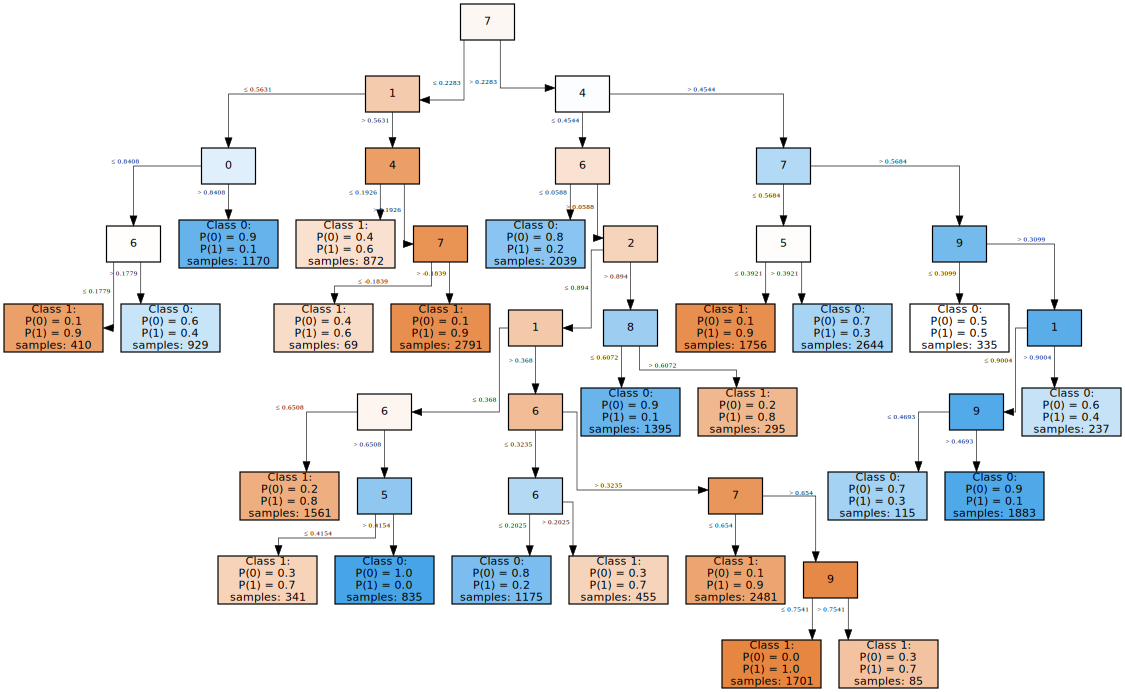

In [47]:
model.draw()

# 6. Concept drift

Um dos aspectos centrais em online learning reside no fato que esperamos que as distribuições dos dados podem ser não-estacionárias. Mas o que isso significa?

Primeiro, vamos pensar num exemplo de distribução estacionária:

> Sabe quando ouvimos falar que a GRANDE-EMPRESA-HYPADA lançou uma rede neural MASTER-BLASTER-ULTRA-POWER-3, com 3 troçalhões de parâmetros, treinada por 3 meses com a energia suficiente para alimentar cidades? E sabe quando ouvimos falar que a base de dados utilizada foi gigante?

Pois bem, os dados não mudam. As regras linguísticas no textos de entrada (supondo um modelo de linguagem natural) ou a semântica visual das imagens (supondo um modelo de visão computacional), ou qualquer outro exemplo, tudo isso é estático. Um cachorro continuará sendo um cachorro (independente do ângulo -- dependendo da forma de captação das imagens isso poderia ser um problema). Uma palavra tem um conjunto de sinônimos e significados.

A regra do jogo não-muda. Mas e se mudasse?

Essa mudança, ou deriva de conceito (concept drift) pode ocorrer em problemas do mundo real. Exemplo:

- padrões de consumo (papel higiênico e alcool em gel no início da pandemia)
- questões relacionadas a clima: energia sustentável
- trânsito, rotas

Umas das áreas de pesquisa (sim, uma área completa de pesquisa) em online learning busca criar detectores para essas situações, bem como algoritmos de aprendizado de máquina que sejam capazes de se adaptar mudanças de conceitos.

Estou longe de ser um especialista nesse tópico, mas vou dar um panorama de como as coisas acontecem.

Suponha que temos um problema de classificação e estamos monitorando os erros do nosso classificador. Nós assinalamos com $0$ quando o modelo acerta (erro zero) e $1$ quando o modelo erra.

In [83]:
rng = random.Random(8)

for _ in range(10):
    print(rng.choices([0, 1], weights=[0.7, 0.3])[0])

0
1
0
1
0
0
1
0
0
0


Podemos passar esses valores para um detector de drifts:

In [87]:
from river import drift

detector = drift.ADWIN(delta=0.01)

vals = rng.choices([0, 1], weights=[0.7, 0.3], k=500)
for i, v in enumerate(vals):
    in_drift, _ = detector.update(v)
    
    if in_drift:
        print(f"Drift detectado em {i}")

E se a distribuição mudar?

In [88]:
detector = drift.ADWIN(delta=0.05)

vals = rng.choices([0, 1], weights=[0.7, 0.3], k=500)
vals.extend(rng.choices([0, 1], weights=[0.2, 0.8], k=500))
for i, v in enumerate(vals):
    in_drift, _ = detector.update(v)
    
    if in_drift:
        print(f"Drift detectado em {i}")
        # Pratica usual
        detector.reset()

Drift detectado em 575


O ADWIN é um dos detectores mais utilizados, mas existem várias alternativas. Além disso, normalmente, os detectores são utilizados como componentes na criação de modelos preditivos. A forma na qual eles são utilizados difere de modelo para modelo. Uma característica é comum entre a maioria dos detectores de drift: eles são univariados.

# 7. Exemplos de algoritmos

Existem muitos algoritmos de aprendizado online. Uns são bem diferentes, outros são modificações de outros algoritmos. Assim como em aprendizado de máquina tradicional, existem opções para todo gosto.

As listas a seguir não são extensivas de modo algum. São apenas o que eu fui lembrando e o que eu vejo de popular por aí (obviamente com o meu viés pessoal). Uma boa pedida é consultar a documentação do River para ver o que há de disponível por lá!

Mostrarei de forma breve seu uso e, quando aplicável, quais dos seus hiper-parâmetros são os mais "sensíveis", na minha experiência.

---
---

**Dica:** Se **dúvidas** específicas surgirem acerca de alguma família, me **interrompam**. Posso **comentar** mais **detalhes** e ir deixando a conversa mais técnica.

---
---

## 7.1. Classificação

Abordaremos uma lista de algoritmos para classificação. Se um algoritmo foi projetado apenas para classificação binária e o problema em questão é multiclasses, as ferramentas do módulo `multiclass` podem ser utilizadas como um wrapper:

- `OneVsOneClassifier`
- `OneVsRestClassifier`
- `OutputCodeClassifier`

### 7.1.1. Logistic Regression

Versão incremental de Logistic Regression (para classificação binária). Pode ser treinada com vários otimizadores. Por padrão usa o `Stochastic Gradient Descent`.


Não tenho muitas dicas específicas acerca dessa família. Mas todo o conhecimento ligado a redes neurais tende a ser útil aqui.

É possível ajustar:

- O otimizador
- O algortmo de inicialização
- Adicionar regularização L2
- A função de perda
- entre outros

**Exemplo:**

In [48]:
from river import datasets
from river import linear_model
from river import optim
from river import preprocessing

dataset = datasets.Phishing()

model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression(optimizer=optim.Adam(), l2=0.01)
)

metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=100)

[100] Accuracy: 81.00%
[200] Accuracy: 82.50%
[300] Accuracy: 83.67%
[400] Accuracy: 84.00%
[500] Accuracy: 84.20%
[600] Accuracy: 84.33%
[700] Accuracy: 85.57%
[800] Accuracy: 85.38%
[900] Accuracy: 86.00%
[1,000] Accuracy: 87.00%
[1,100] Accuracy: 87.36%
[1,200] Accuracy: 87.33%


Accuracy: 87.36%

Podemos inspecionar como as decisões foram feitas:

Uma variante de Logistic Regression é SoftMax Regression (voltada para problemas multi-classe e mais robusta a outliers):

In [49]:
dataset = datasets.ImageSegments()

model = (
    preprocessing.StandardScaler() |
    linear_model.SoftmaxRegression()
)

metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=200, show_memory=True, show_time=True)

[200] Accuracy: 67.34% – 0:00:00.077243 – 16.92 KB
[400] Accuracy: 73.18% – 0:00:00.134205 – 17.41 KB
[600] Accuracy: 73.62% – 0:00:00.225217 – 17.41 KB
[800] Accuracy: 75.97% – 0:00:00.295104 – 17.41 KB
[1,000] Accuracy: 77.48% – 0:00:00.348430 – 17.41 KB
[1,200] Accuracy: 79.32% – 0:00:00.399797 – 17.41 KB
[1,400] Accuracy: 80.34% – 0:00:00.442778 – 17.41 KB
[1,600] Accuracy: 81.11% – 0:00:00.485025 – 17.41 KB
[1,800] Accuracy: 81.77% – 0:00:00.528172 – 17.41 KB
[2,000] Accuracy: 82.19% – 0:00:00.575697 – 17.41 KB
[2,200] Accuracy: 82.63% – 0:00:00.621930 – 17.41 KB


Accuracy: 82.55%

### 7.1.2. Hoeffding Tree (e variantes)

Estão entre os modelos mais populares em stream mining. Historicamente um dos algoritmos mais usados, senão o mais usado. Minha pesquisa de doutorado contempla árvores de decisão e ensembles online. Existem vários classificadores no River baseados em árvores de decisão. Grande parte deles pertencem a família das *Hoeffding Trees*.

Hoeffding Trees (HT) têm esse nome porque elas se baseiam numa grandeza estatística chamada *Hoeffding bound* para decidir quando fazer uma divisão. Essa medida traz indícios que um split feito de forma incremental seria o mesmo que seria feito em um algoritmo de árvore tradicional (desde que observações suficientes sejam feitas).

Existem três variantes principais das HTs:

- Hoeffding Tree: versão padrão
- Hoeffding Adaptive Tree: adiciona detectores de deriva de conceito em cada nó de decisão. Se uma mudança é detectada, uma nova sub-árvore é treinada (no *background*) e eventualmente virá a substituir o ramo afetado.
- Extremely Fast Decision Tree: Faz splits mais rapidamente, mas periodicamente revisita as decisões feitas e vai reconstruindo as árvores.

**Principais parâmetros para ajuste comum a todas as HTs:**

- `grace_period`: intervalos entre tentativas de *splits*.
- `split_confidence`: o quão "certas" sobre uma decisão as árvores devem estar, de forma fazer um *split*. A "certeza" é dada por `1 - split_confidence`.
- `tie_threshold`: threshold abaixo do qual um split será feito, mesmo se não houver plena certeza que o melhor candidato para *split* é realmente a melhor escolha.
- `max_depth`: profundeza máxima que uma árvore pode alcançar.

Eu escrevi um [tutorial](https://riverml.xyz/dev/user-guide/on-hoeffding-trees/) sobre HTs que aprofunda mais o que é possível se fazer com esse tipo de preditor.

**Exemplo:**

In [50]:
from river import tree


dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)
model = tree.HoeffdingAdaptiveTreeClassifier(seed=42)
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=1000, show_memory=True, show_time=True)

[1,000] Accuracy: 56.26% – 0:00:00.995915 – 34.38 KB
[2,000] Accuracy: 57.78% – 0:00:01.888056 – 34.44 KB
[3,000] Accuracy: 58.15% – 0:00:02.863016 – 34.51 KB
[4,000] Accuracy: 57.81% – 0:00:03.751004 – 34.51 KB
[5,000] Accuracy: 57.55% – 0:00:04.640327 – 34.51 KB
[6,000] Accuracy: 57.36% – 0:00:05.494765 – 34.57 KB
[7,000] Accuracy: 57.77% – 0:00:06.546546 – 66.03 KB
[8,000] Accuracy: 58.68% – 0:00:07.589658 – 66.28 KB
[9,000] Accuracy: 59.06% – 0:00:08.531908 – 71.58 KB
[10,000] Accuracy: 59.34% – 0:00:09.600173 – 97.75 KB
[11,000] Accuracy: 59.96% – 0:00:10.765590 – 97.94 KB
[12,000] Accuracy: 60.40% – 0:00:11.816630 – 98.06 KB
[13,000] Accuracy: 61.01% – 0:00:12.816044 – 98.19 KB
[14,000] Accuracy: 61.28% – 0:00:13.996072 – 98.25 KB
[15,000] Accuracy: 61.29% – 0:00:14.942867 – 128.44 KB


Accuracy: 61.29%

Como já vimos anteriormente, podemos visualizar a estrutura da árvore.

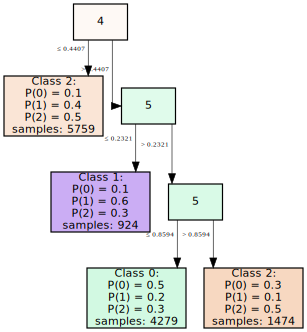

In [51]:
model.draw()

Também é possível inspecionar como uma decisão é tomada:

In [52]:
dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)

x, y = next(dataset)

print(model.debug_one(x))

4 ≤ 0.44069887341009073
Class 2:
	P(0) = 0.1
	P(1) = 0.4
	P(2) = 0.5



### 7.1.3. Naive Bayes

O Naive Bayes é inerentemente incremental. Assim, é possível atualizar as contagens ou estimativas das distribuições de forma incremental.

Modelos disponíveis:

- BernoulliNB, ComplementNB e MultinomialNB: voltados para os casos onde os dados são contagens (bag-of-words), ou a saída do TF-IDF.
-  GaussianNB: discretiza as features numéricas utilizando uma distribuição gaussiana por classe.

**Exemplo:**

In [53]:
dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)


# Note que o modelo selecionado não tem trata a deriva de conceitos
model = naive_bayes.GaussianNB()
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=1000, show_memory=True, show_time=True)

[1,000] Accuracy: 56.86% – 0:00:00.655481 – 18.37 KB
[2,000] Accuracy: 57.58% – 0:00:01.321623 – 18.37 KB
[3,000] Accuracy: 57.59% – 0:00:01.981769 – 18.37 KB
[4,000] Accuracy: 57.39% – 0:00:02.637439 – 18.37 KB
[5,000] Accuracy: 57.07% – 0:00:03.300461 – 18.37 KB
[6,000] Accuracy: 56.88% – 0:00:03.959022 – 18.37 KB
[7,000] Accuracy: 56.99% – 0:00:04.616742 – 18.37 KB
[8,000] Accuracy: 57.46% – 0:00:05.274807 – 18.37 KB
[9,000] Accuracy: 57.60% – 0:00:05.932731 – 18.37 KB
[10,000] Accuracy: 57.43% – 0:00:06.762030 – 18.37 KB
[11,000] Accuracy: 57.16% – 0:00:07.437030 – 18.37 KB
[12,000] Accuracy: 56.70% – 0:00:08.172555 – 18.37 KB
[13,000] Accuracy: 56.48% – 0:00:08.947927 – 18.37 KB
[14,000] Accuracy: 56.20% – 0:00:09.715797 – 18.37 KB
[15,000] Accuracy: 55.80% – 0:00:10.375563 – 18.37 KB


Accuracy: 55.80%

### 6.1.4. Adaptive Random Forest

A adaptive random forest (ARF) é uma versão incremental do algoritmo Random Forest e combinas os seguintes ingredientes:

- Hoeffding Trees com pitadas de aleatoriadade, como *base learners* (ingrediente principal)
- Detectores de deriva de conceito por árvore
    - árvores "reserva" são treinadas em *background* caso drifts são detectados
- Bagging na versão online

Além de todos os parâmetros das HTs, alguns parâmetros notáveis da ARF são:

- `warning_detector` e `drift_detector`: detectores de warning e drift
- `n_models`: o número de árvores
- `max_features`: o número de features que será considerado por árvore durante *splits*

**Exemplo:**

In [54]:
from river import ensemble


dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)

model = ensemble.AdaptiveRandomForestClassifier(seed=8)
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=1000, show_memory=True, show_time=True)

[1,000] Accuracy: 68.07% – 0:00:03.015571 – 1.01 MB
[2,000] Accuracy: 73.04% – 0:00:05.996491 – 1.08 MB
[3,000] Accuracy: 75.03% – 0:00:08.940292 – 2.7 MB
[4,000] Accuracy: 76.42% – 0:00:11.826764 – 2.96 MB
[5,000] Accuracy: 77.24% – 0:00:14.620262 – 3.39 MB
[6,000] Accuracy: 78.13% – 0:00:17.384333 – 3.91 MB
[7,000] Accuracy: 78.54% – 0:00:20.270450 – 5.1 MB
[8,000] Accuracy: 79.02% – 0:00:23.116703 – 5.75 MB
[9,000] Accuracy: 79.00% – 0:00:26.207124 – 7.07 MB
[10,000] Accuracy: 79.17% – 0:00:29.432273 – 6.33 MB
[11,000] Accuracy: 78.93% – 0:00:32.284529 – 7.71 MB
[12,000] Accuracy: 78.76% – 0:00:35.522819 – 9.11 MB
[13,000] Accuracy: 78.82% – 0:00:38.481643 – 8.12 MB
[14,000] Accuracy: 78.64% – 0:00:41.635884 – 6.41 MB
[15,000] Accuracy: 78.45% – 0:00:44.567332 – 7.55 MB


Accuracy: 78.45%

### 7.1.5. Streaming Random Patches

Na ARF e random forest em geral, cada vez que um nó da árvore é dividido, um novo sub-conjunto das features é selecionado. Apenas esse subconjunto é considerado nas decisões. Esse processo pode ser referido como amostragem local de features. A (A)RF também faz amostragem de instâncias com reposição (*bagging*).

O Streaming Random Patches (SRP) também faz amostragem de instâncias via bagging. No entanto, a amostragem de features é global: feita apenas uma vez por modelo no ensemble. Além disso, o SRP não limita os membros do ensemble à árvores de decisão: qualquer classificador pode ser utilizado 😁

A detecção e reação a derivas de conceito (concept drift) é igual ao mecanismo adotado na ARF.

Quanto aos hiperparâmetros mais notáveis:

- `model`: o classificador base
- `n_models`: o número de classificadores no ensemble
- `warning_detector` e `drift_detector`: o mesmo que na ARF

**Exemplo:**

In [57]:
from river import neighbors

dataset = synth.RandomRBFDrift(
    seed_model=7, seed_sample=8, change_speed=0.0001, n_classes=3,
).take(15000)


model = ensemble.SRPClassifier(
    neighbors.KNNClassifier(),
    n_models=5, seed=8,
    training_method="subspaces"
)
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset, model, metric, print_every=1000, show_memory=True, show_time=True)

[1,000] Accuracy: 81.38% – 0:00:04.214506 – 1.59 MB
[2,000] Accuracy: 83.89% – 0:00:10.410419 – 1.59 MB
[3,000] Accuracy: 85.16% – 0:00:16.772803 – 1.59 MB
[4,000] Accuracy: 84.85% – 0:00:23.251055 – 1.59 MB
[5,000] Accuracy: 85.06% – 0:00:29.509919 – 1.59 MB
[6,000] Accuracy: 85.05% – 0:00:35.778462 – 1.6 MB
[7,000] Accuracy: 85.07% – 0:00:42.245203 – 1.6 MB
[8,000] Accuracy: 84.80% – 0:00:48.561115 – 1.6 MB
[9,000] Accuracy: 84.48% – 0:00:55.022085 – 1.6 MB
[10,000] Accuracy: 84.38% – 0:01:01.597720 – 1.6 MB
[11,000] Accuracy: 84.03% – 0:01:07.895160 – 1.59 MB
[12,000] Accuracy: 83.71% – 0:01:14.226302 – 1.59 MB
[13,000] Accuracy: 83.68% – 0:01:21.088692 – 1.59 MB
[14,000] Accuracy: 83.39% – 0:01:27.403901 – 1.59 MB
[15,000] Accuracy: 83.19% – 0:01:33.746779 – 1.6 MB


Accuracy: 83.19%

## 7.2. Regressão

### 7.2.1. Linear Regression

### 7.2.2. Hoeffding Tree

### 7.2.3. AMRules

### 7.2.4. Adaptive Random Forest

### 7.7.5. Streaming Random Patches

### 7.3. Clustering

## 7.4. Anomaly detection

# 8. Expert stuff

# 9. Pipelines e pré-processamento

# 10. Exemplo completo